# Titanic: Machine Learning Competition
___

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [81]:
%%javascript
//This is used to make the table of contents!! 
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

Basic imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Some useful functions:

In [84]:
from sklearn.metrics import confusion_matrix

def plot_confusion(ytest, y_model):
    """Plot the heatmap of the confusion_matrix(ytest, y_model)"""
    
    confusion = confusion_matrix(ytest, y_model)
    sns.heatmap(confusion, annot=True, square = True, cbar=False, cmap='YlGnBu')
    plt.xlabel('predicted values', size=14)
    plt.ylabel('true values', size=14)
    return plt.show()

In [85]:
from sklearn.metrics import classification_report 

def compare_binary_classification(models, Xtrain, Xtest, ytrain, ytest):
    """Return a DataFrame with precision, recall and f1 score for each model(hypermarameters)"""
    
    report0 = pd.DataFrame() # Precision, recall, f1_score and support for label 0
    report1 = pd.DataFrame() # Precision, recall, f1_score and support for label 1
    
    for name, model in models: # Models is a tuple of tuples ('model name', model(hyperparameters))
        y_model = model.fit(Xtrain, ytrain).predict(Xtest)
        report0[name] = pd.DataFrame(classification_report(ytest, y_model, output_dict=True)).iloc[:, 0]
        report1[name] = pd.DataFrame(classification_report(ytest, y_model, output_dict=True)).iloc[:, 1]

    return report0.T, report1.T

In [86]:
from sklearn.model_selection import GridSearchCV

def parameter_tuning(model, Xtrain, ytrain, param_grid, cv=5, n_jobs=1):
    """This function returns the best_parameter and the best estimator of the grid search
    Note: the param_grid must be defined accordingly to the model tested"""
    
    gs = GridSearchCV(model, param_grid, cv=cv, verbose=1, n_jobs=n_jobs)
    gs.fit(Xtrain, ytrain)
    
    return gs.best_params_, gs.best_estimator_

## Feature Engineering

I will follow the feature engineering process determined with the EDA performed in 'The Data' notebook, here summarized:

- I will change the entries of the **`'Pclass'`** column into strings, as it is a **categorical feature**.
- I will **drop** the features that need too much preprocessing or have a lot of missing data, such as **`'Name'`, `'Ticket'` and `'Cabin'`**.
- I will **fill the missing values** of **`'Age'`** using the mean, and the missing values of **`'Embarked'`** using the mode;
- I will **encode the categorical features**.

In [87]:
data = pd.read_csv('input/train.csv', index_col=0)
data['Pclass'] = data['Pclass'].apply(str)
data.pop('Name')
data.pop('Ticket')
data.pop('Cabin')
data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode())
data = pd.get_dummies(data, prefix_sep='_')#, drop_first=True)
data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


The **target array**

In [88]:
y = data['Survived']
y.shape

(891,)

The **features matrix**:

In [89]:
X = data.drop('Survived', axis=1)
X.shape
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


I am going to split the data into a training and a testing subsets:

In [90]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

## Methodology

### 1. Untouched Data

The machine learning algorithms I am going to compare are:

- Gaussuan Naive Bayes
- SVC
- K-Nearest Neighbors
- Decision Tree
- Random Forest

Before tuning the hyperparameters, I am going to compare the algorithms using the `compare_binary_classification` function:

In [91]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate models
models = []
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(kernel='linear', random_state=1))) # Using the linear kernel
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('DTC', DecisionTreeClassifier(random_state=1)))
models.append(('RFC', RandomForestClassifier(n_estimators=1000, random_state=1)))

# Comparing the models
r0, r1 = compare_binary_classification(models, Xtrain, Xtest, ytrain, ytest)

`ro` is a DataFrame containing the precision, recall and f1_score for label 0, i.e. the people who died in the Titanic

In [92]:
r0

,f1-score,precision,recall,support
NB,0.809160,0.834646,0.785185,135.0
SVC,0.843636,0.828571,0.859259,135.0
KNN,0.774908,0.772059,0.777778,135.0
DTC,0.792453,0.807692,0.777778,135.0
RFC,0.810219,0.798561,0.822222,135.0


`r1` is a DataFrame containing the precision, recall and f1_score for label 1, i.e. the people who survived the Titanic tragedy:

In [93]:
r1

,f1-score,precision,recall,support
NB,0.728261,0.697917,0.761364,88.0
SVC,0.748538,0.771084,0.727273,88.0
KNN,0.651429,0.655172,0.647727,88.0
DTC,0.696133,0.677419,0.715909,88.0
RFC,0.697674,0.714286,0.681818,88.0


#### 1.1 Gaussian Naive Bayes 

Gaussina Naive Bayes has  almost no parameters, hence no hyperparameter tuning will be performed.

Note: one could in principle tune the training size. I will not do that in this first anlysis.

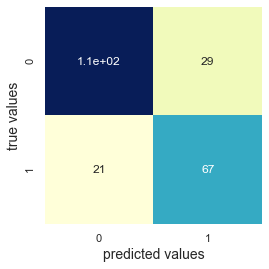

In [94]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
y_model = gauss.fit(Xtrain, ytrain).predict(Xtest)

confusion_GNB = plot_confusion(ytest, y_model)
confusion_GNB

In [185]:
print(classification_report(ytest, y_model, target_names=['died', 'survived']))

              precision    recall  f1-score   support

        died       0.81      0.80      0.80       144
    survived       0.64      0.66      0.65        79

    accuracy                           0.75       223
   macro avg       0.73      0.73      0.73       223
weighted avg       0.75      0.75      0.75       223



#### 1.2 Support Vector Machine 

Tuning the hyperparameters using `parameter_tuning`:

In [95]:
# The regularization parameter. 
Cs = [0.1, 1, 10]

# Creating the parameter grid
param_grid = {'C': Cs}

# Tuning the parameters
best_params_SVC, tuned_SVC = parameter_tuning(SVC(kernel='linear', random_state=1), Xtrain, ytrain, param_grid, cv=5, n_jobs=-1)
best_params_SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   36.7s finished


{'C': 1}

In [96]:
y_model = tuned_SVC.fit(Xtrain, ytrain).predict(Xtest)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       135
           1       0.77      0.73      0.75        88

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



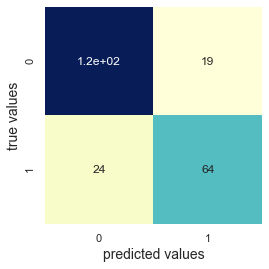

In [97]:
confusion_SVC = plot_confusion(ytest, y_model)
confusion_SVC

#### 1.3 K-Nearest Neighbors

In [98]:
## Number of neighbors to use by default for kneighbors queries.
n_neighbors = [3, 5, 11, 19, 21]
# Weight function used in prediction. 
weights = ['uniform', 'distance']
# The distance metric to use for the tree.
metrics = ['euclidean', 'minkowski', 'manhattan']
# Algorithm used to copute the nearest neighbor
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Creating the parameter grid
param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'metric': metrics,
              'algorithm': algorithms}

# Tuning the parameters
best_params_KNN, tuned_KNN = parameter_tuning(KNeighborsClassifier(), Xtrain, ytrain, param_grid, 5, -1)
best_params_KNN

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.1s finished


{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 19,
 'weights': 'distance'}

In [99]:
y_model = tuned_KNN.fit(Xtrain, ytrain).predict(Xtest)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       135
           1       0.67      0.67      0.67        88

    accuracy                           0.74       223
   macro avg       0.73      0.73      0.73       223
weighted avg       0.74      0.74      0.74       223



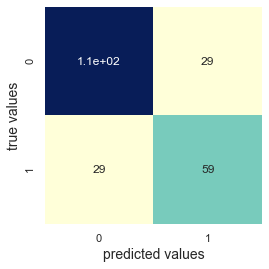

In [100]:
confusion_KNN = plot_confusion(ytest, y_model)

#### 1.4 Decision Tree

In [101]:
# Maximum number of levels in tree
max_depth = np.arange(1, 11)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Grow a tree with max_leaf_nodes in best-first fashion
max_leaf_nodes = list(range(15, 35))
# Weights associated with classes in the form {class_label: weight}
class_weight = ['None', 'balanced']


# Creating the parameter grid
param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'max_leaf_nodes': max_leaf_nodes,
              'class_weight': class_weight}

# Tuning the parameters
best_params_DTC, tuned_DTC = parameter_tuning(DecisionTreeClassifier(random_state=1), Xtrain, ytrain, param_grid, 5, -1)
best_params_DTC

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    9.8s finished


{'class_weight': 'balanced',
 'max_depth': 9,
 'max_leaf_nodes': 29,
 'min_samples_split': 2}

In [102]:
y_model = tuned_DTC.fit(Xtrain, ytrain).predict(Xtest)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       135
           1       0.71      0.76      0.74        88

    accuracy                           0.78       223
   macro avg       0.77      0.78      0.78       223
weighted avg       0.79      0.78      0.79       223



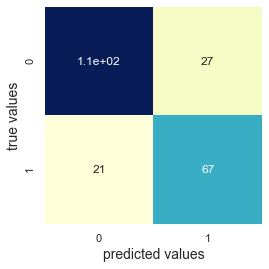

In [103]:
confusion_DTC = plot_confusion(ytest, y_model)

#### 1.5 Random Forest 

Now we will tune the hyperparameters of `RandomForestClassifier`

In [104]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 50, 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Weights associated with classes in the form {class_label: weight}
class_weight = ['None', 'balanced']

# Creating the parameter grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'class_weight': class_weight}

# Tuning the parameters
best_params_RFC, tuned_RFC = parameter_tuning(RandomForestClassifier(random_state=1), Xtrain, ytrain, param_grid, 5, -1)
best_params_RFC

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2725 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 4049 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 7193 out of 7200 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  1.4min finished


{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [105]:
y_model = tuned_RFC.fit(Xtrain, ytrain).predict(Xtest)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       135
           1       0.75      0.68      0.71        88

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



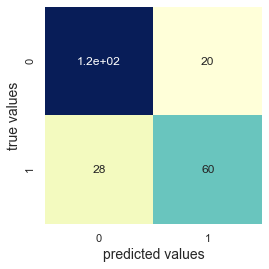

In [106]:
confusion_RFC = plot_confusion(ytest, y_model)

#### Comparing the models after the hyperparameter tuning 

In [107]:
# Instantiate models
models = []
models.append(('GNB', GaussianNB()))
models.append(('SVC', tuned_SVC))
models.append(('KNN', tuned_KNN))
models.append(('DTC', tuned_DTC))
models.append(('RFC', tuned_RFC))

r0, r1 = compare_binary_classification(models, Xtrain, Xtest, ytrain, ytest)

In [108]:
r0

,f1-score,precision,recall,support
GNB,0.809160,0.834646,0.785185,135.0
SVC,0.843636,0.828571,0.859259,135.0
KNN,0.785185,0.785185,0.785185,135.0
DTC,0.818182,0.837209,0.800000,135.0
RFC,0.827338,0.804196,0.851852,135.0


In [109]:
r1

,f1-score,precision,recall,support
GNB,0.728261,0.697917,0.761364,88.0
SVC,0.748538,0.771084,0.727273,88.0
KNN,0.670455,0.670455,0.670455,88.0
DTC,0.736264,0.712766,0.761364,88.0
RFC,0.714286,0.750000,0.681818,88.0


### 2. Scaled Data 

next will be:

Next, like in most other models, you should scale your data. Remember that there are very few situations where data shouldn’t be scaled. If you’re reading this post for educational purposes, there’s a high probability that you’re not experienced enough to be deciding to not scale. Scaling is a simple process that can be done in just a few lines code. After importing, instantiate the StandardScaler(), fit_transform to the train set, and transform the test set.

In [110]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(Xtrain)
X_test = ss.fit_transform(Xtest)

In [111]:
#Instantiate models
models = []
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(kernel='linear', random_state=1))) # Using the linear kernel
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('DTC', DecisionTreeClassifier(random_state=1)))
models.append(('RFC', RandomForestClassifier(n_estimators=1000, random_state=1)))

# Comparing the models
r0, r1 = compare_binary_classification(models, X_train, X_test, ytrain, ytest)

In [112]:
r0

,f1-score,precision,recall,support
NB,0.822642,0.838462,0.807407,135.0
SVC,0.841727,0.818182,0.866667,135.0
KNN,0.735632,0.761905,0.711111,135.0
DTC,0.592920,0.736264,0.496296,135.0
RFC,0.766917,0.778626,0.755556,135.0


In [113]:
r1

,f1-score,precision,recall,support
NB,0.740331,0.720430,0.761364,88.0
SVC,0.738095,0.775000,0.704545,88.0
KNN,0.627027,0.597938,0.659091,88.0
DTC,0.581818,0.484848,0.727273,88.0
RFC,0.655556,0.641304,0.670455,88.0


#### 1.1 Gaussian Naive Bayes 

Gaussina Naive Bayes has  almost no parameters, hence no hyperparameter tuning will be performed.

Note: one could in principle tune the training size. I will not do that in this first anlysis.

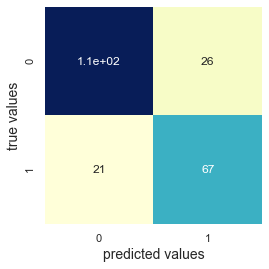

In [114]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
y_model = gauss.fit(X_train, ytrain).predict(X_test)

confusion_GNB = plot_confusion(ytest, y_model)
confusion_GNB

In [115]:
print(classification_report(ytest, y_model, target_names=['died', 'survived']))

              precision    recall  f1-score   support

        died       0.84      0.81      0.82       135
    survived       0.72      0.76      0.74        88

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



#### 1.2 Support Vector Machine 

Tuning the hyperparameters using `parameter_tuning`:

In [155]:
# The regularization parameter. 
Cs = [0.001, 0.01, 0.1]

# Creating the parameter grid
param_grid = {'C': Cs}

# Tuning the parameters
best_params_SVC, tuned_SVC = parameter_tuning(SVC(kernel='linear', class_weight='balanced', random_state=1), X_train, ytrain, param_grid, cv=5, n_jobs=-1)
best_params_SVC

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.2s finished


{'C': 0.01}

In [156]:
y_model = tuned_SVC.fit(X_train, ytrain).predict(X_test)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       135
           1       0.77      0.73      0.75        88

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



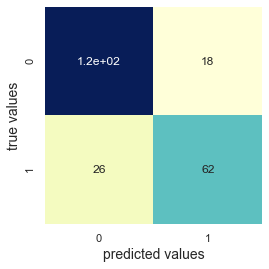

In [118]:
confusion_SVC = plot_confusion(ytest, y_model)
confusion_SVC

#### 1.3 K-Nearest Neighbors

In [119]:
## Number of neighbors to use by default for kneighbors queries.
n_neighbors = [3, 5, 11, 19, 21]
# Weight function used in prediction. 
weights = ['uniform', 'distance']
# The distance metric to use for the tree.
metrics = ['euclidean', 'minkowski', 'manhattan']
# Algorithm used to copute the nearest neighbor
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Creating the parameter grid
param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'metric': metrics,
              'algorithm': algorithms}

# Tuning the parameters
best_params_KNN, tuned_KNN = parameter_tuning(KNeighborsClassifier(), X_train, ytrain, param_grid, 5, -1)
best_params_KNN

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.7s finished


{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_neighbors': 3,
 'weights': 'uniform'}

In [120]:
y_model = tuned_KNN.fit(X_train, ytrain).predict(X_test)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       135
           1       0.72      0.66      0.69        88

    accuracy                           0.76       223
   macro avg       0.75      0.74      0.75       223
weighted avg       0.76      0.76      0.76       223



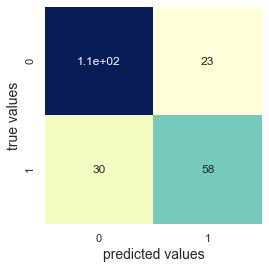

In [121]:
confusion_KNN = plot_confusion(ytest, y_model)

#### 1.4 Decision Tree

In [122]:
# Maximum number of levels in tree
max_depth = np.arange(1, 11)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Grow a tree with max_leaf_nodes in best-first fashion
max_leaf_nodes = list(range(15, 35))
# Weights associated with classes in the form {class_label: weight}
class_weight = ['None', 'balanced']


# Creating the parameter grid
param_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'max_leaf_nodes': max_leaf_nodes,
              'class_weight': class_weight}

# Tuning the parameters
best_params_DTC, tuned_DTC = parameter_tuning(DecisionTreeClassifier(random_state=1), X_train, ytrain, param_grid, 5, -1)
best_params_DTC

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:    6.3s finished


{'class_weight': 'balanced',
 'max_depth': 9,
 'max_leaf_nodes': 29,
 'min_samples_split': 2}

In [123]:
y_model = tuned_DTC.fit(X_train, ytrain).predict(X_test)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       135
           1       0.73      0.69      0.71        88

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.76       223
weighted avg       0.77      0.78      0.77       223



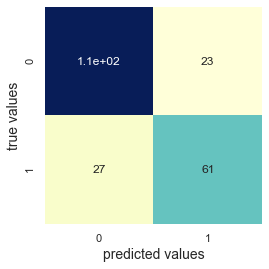

In [124]:
confusion_DTC = plot_confusion(ytest, y_model)

#### 1.5 Random Forest 

Now we will tune the hyperparameters of `RandomForestClassifier`

In [125]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 50, 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Weights associated with classes in the form {class_label: weight}
class_weight = ['None', 'balanced']

# Creating the parameter grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'class_weight': class_weight}

# Tuning the parameters
best_params_RFC, tuned_RFC = parameter_tuning(RandomForestClassifier(random_state=1), X_train, ytrain, param_grid, 5, -1)
best_params_RFC

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 3553 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7081 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  1.7min finished


{'bootstrap': False,
 'class_weight': 'balanced',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [126]:
y_model = tuned_RFC.fit(X_train, ytrain).predict(X_test)

print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       135
           1       0.73      0.69      0.71        88

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



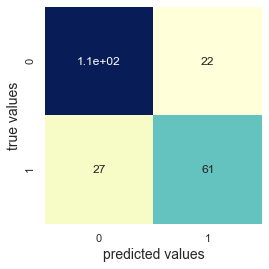

In [127]:
confusion_RFC = plot_confusion(ytest, y_model)

### Comparing the models after the hyperparameter tuning 

In [157]:
# Instantiate models
models = []
models.append(('GNB', GaussianNB()))
models.append(('SVC', tuned_SVC))
models.append(('KNN', tuned_KNN))
models.append(('DTC', tuned_DTC))
models.append(('RFC', tuned_RFC))

r0_scaled, r1_scaled = compare_binary_classification(models, X_train, X_test, ytrain, ytest)

In [158]:
r0_scaled

,f1-score,precision,recall,support
GNB,0.822642,0.838462,0.807407,135.0
SVC,0.843636,0.828571,0.859259,135.0
KNN,0.808664,0.788732,0.829630,135.0
DTC,0.817518,0.805755,0.829630,135.0
RFC,0.821818,0.807143,0.837037,135.0


In [159]:
r1_scaled

,f1-score,precision,recall,support
GNB,0.740331,0.720430,0.761364,88.0
SVC,0.748538,0.771084,0.727273,88.0
KNN,0.686391,0.716049,0.659091,88.0
DTC,0.709302,0.726190,0.693182,88.0
RFC,0.713450,0.734940,0.693182,88.0


## My predictions 

In [187]:
test = pd.read_csv('input/test.csv')

In [165]:
y_model = tuned_SVC.fit(X_train, ytrain).predict(X_test)
print(classification_report(ytest, y_model))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       135
           1       0.77      0.73      0.75        88

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



In [188]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [172]:
#test= test.set_index('PassengerId');

In [189]:
test.pop('Name')
test.pop('Ticket')
test.pop('Cabin');
index = test['PassengerId']
test.pop('PassengerId');

0       892
1       893
2       894
3       895
4       896
5       897
6       898
7       899
8       900
9       901
10      902
11      903
12      904
13      905
14      906
15      907
16      908
17      909
18      910
19      911
20      912
21      913
22      914
23      915
24      916
25      917
26      918
27      919
28      920
29      921
       ... 
388    1280
389    1281
390    1282
391    1283
392    1284
393    1285
394    1286
395    1287
396    1288
397    1289
398    1290
399    1291
400    1292
401    1293
402    1294
403    1295
404    1296
405    1297
406    1298
407    1299
408    1300
409    1301
410    1302
411    1303
412    1304
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [190]:
test['Pclass'] = test['Pclass'].apply(str)

In [191]:
NAs = pd.concat([test.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,86
Fare,1


In [192]:
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test = pd.get_dummies(test, prefix_sep='_')#, drop_first=True)
test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


In [193]:
y_predict = tuned_SVC.predict(test)

In [194]:
test['Survived'] = y_predict
test['PassengerId'] = index

In [196]:
predictions = test[['PassengerId', 'Survived']]
predictions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [197]:
predictions.to_csv('predictions.csv', index=False)

In [198]:
t = pd.read_csv('predictions.csv')
t.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
